# Shooting Method

Boundary-value problems are also ordinary differential equations—the difference is that our two constraints are at boundaries of the domain, rather than both being at the starting point.

For example, consider the ODE
\begin{equation}
y^{\prime\prime} + xy^{\prime} - xy = 2x
\end{equation}
with the boundary conditions $y(0)=1$ and $y(2)=8$.

The numerical methods we have already discussed (e.g., Forward Euler, Runge-Kutta) require values of $y$ and $y^{\prime}$ at the starting point, $x=0$. So we can't use these directly because we are missing $y^{\prime}(0)$. 

But, what if we could *guess* a value for the missing initial condition, then integrate towards the second boundary condition using one of our familiar numerical methods, and then adjust our guess if necessary and repeat? This concept is the **shooting method**.

The shooting method algorithm is:

1. Guess a value of the missing initial condition; in this case, that is $y'(0)$.
2. Integrate the ODE like an initial-value problem, using our existing numerical methods, to get the given boundary condition(s); in this case, that is $y(L)$.
3. Assuming your trial solution for $y(L)$ does not match the given boundary condition, adjust your guess for $y'(0)$ and repeat.

Now, this algorithm will not work particularly well if all your guesses are random/uninformed. Fortunately, we can use linear interpolation to inform a third guess based on two initial attempts:
\begin{align}
\text{guess 3} &= \text{guess 2} + m \left( \text{target} - \text{solution 2} \right) \\
m &= \frac{\text{guess 1} - \text{guess 2}}{\text{solution 1} - \text{solution 2}}
\end{align}
where "target" is the target boundary condition—in this case, $y(L)$.

In [1]:
# import libraries for numerical functions and plotting
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

## Example: linear ODE

Let's try solving the given ODE using the shooting method:
\begin{equation}
y^{\prime\prime} + xy^{\prime} - xy = 2x
\end{equation}
with the boundary conditions $y(0)=1$ and $y(2)=8$.

First, we need to convert this 2nd-order ODE into a system of two 1st-order ODEs, where we can define $u = y'$:
\begin{align}
y' &= u \\
u' &= 2x + xy - xu
\end{align}

Solution 1:  6.00
Solution 2:  11.96
Guess 3:     2.01
Solution 3:  8.00
Target:      8.00


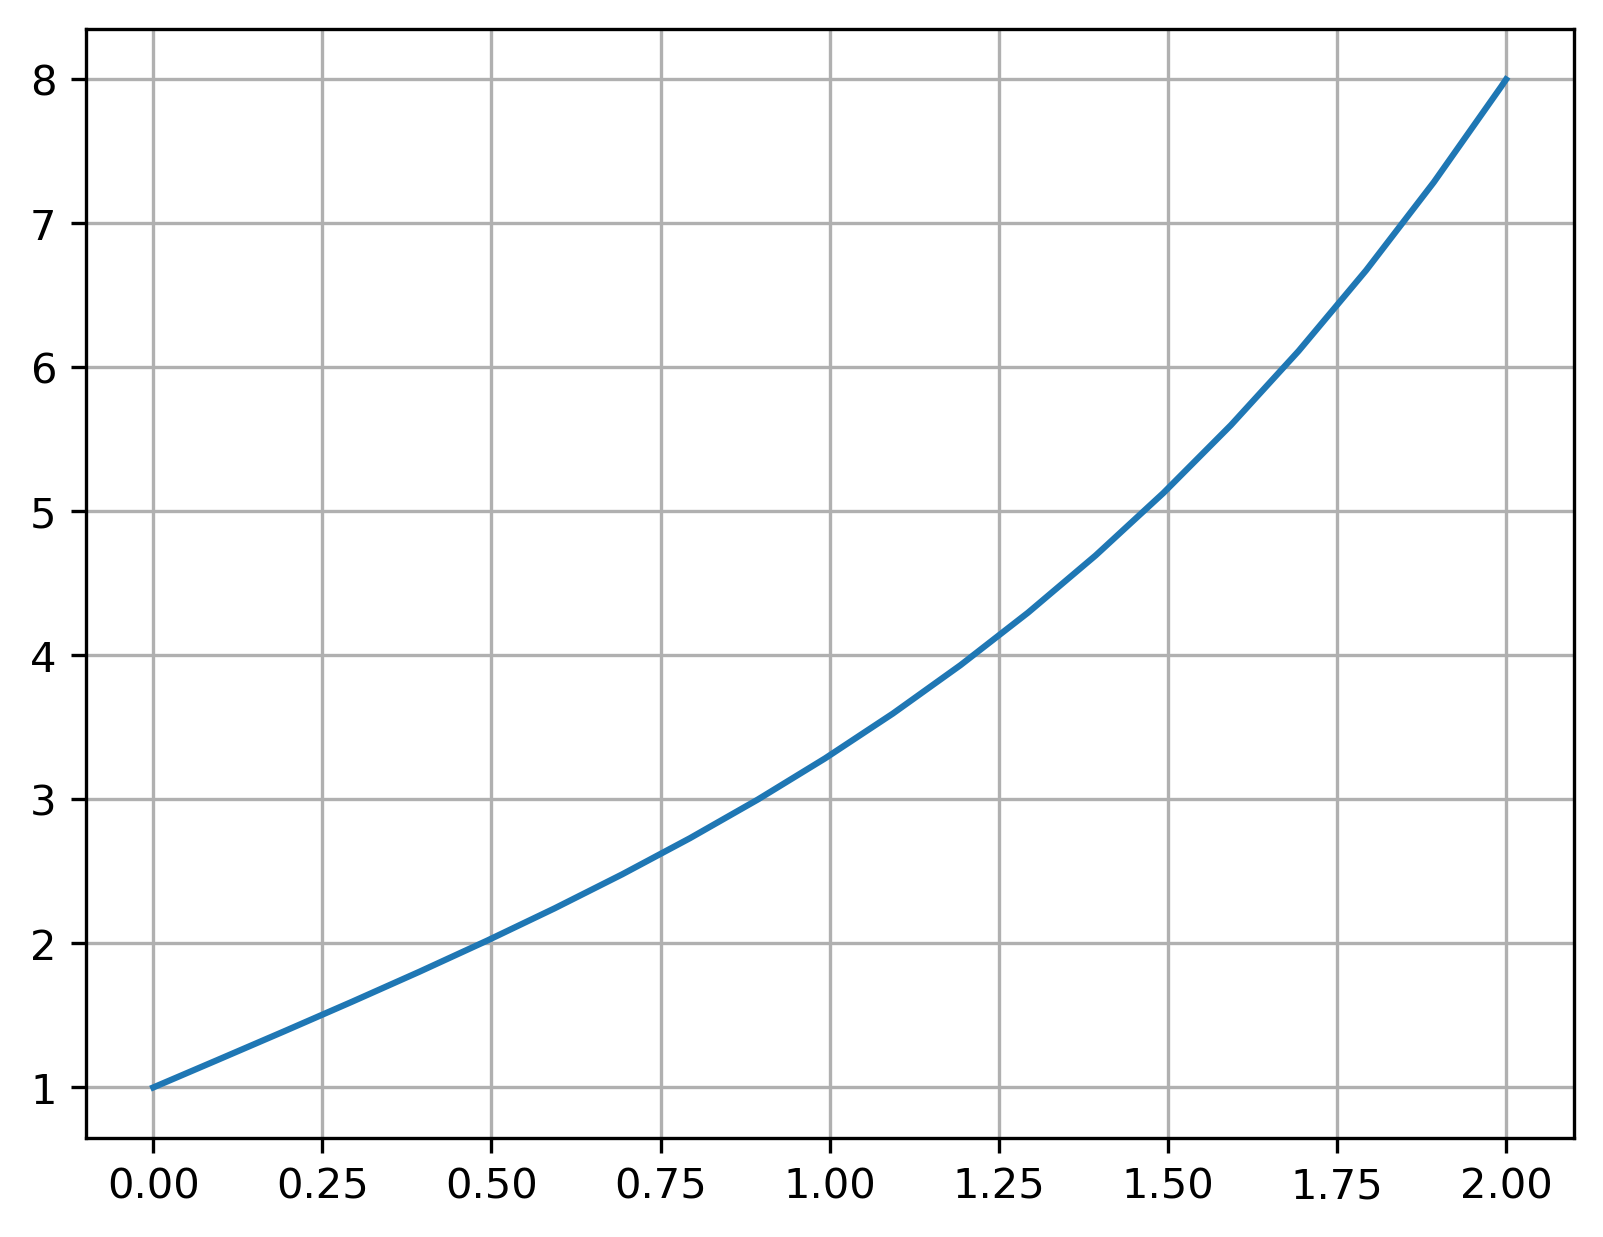

In [29]:
def shooting_rhs(x, y):
    '''Function for dy/dx derivatives'''
    return [y[1], 2*x + x*y[0] - x*y[1]]

# target boundary condition
target = 8

# pick a guess for y'(0)
guess1 = 1
sol1 = solve_ivp(shooting_rhs, [0, 2], [1, guess1])
print(f'Solution 1: {sol1.y[0,-1]: .2f}')

# pick a second guess for y'(0)
guess2 = 4
sol2 = solve_ivp(shooting_rhs, [0, 2], [1, guess2])
print(f'Solution 2: {sol2.y[0,-1]: .2f}')

# now use linear interpolation to find a new guess
m = (guess1 - guess2) / (sol1.y[0,-1] - sol2.y[0,-1])
guess3 = guess2 + m * (target - sol2.y[0,-1])
print(f'Guess 3:    {guess3: .2f}')

sol3 = solve_ivp(shooting_rhs, [0, 2], [1, guess3], max_step=0.1)
print(f'Solution 3: {sol3.y[0,-1]: .2f}')
print(f'Target:     {target: .2f}')

plt.plot(sol3.t, sol3.y[0,:])
plt.grid()
plt.show()

As you can see, using linear interpolation, we are able to find the correct guess for the missing initial condition $y'(0)$ with in just three steps. This works so well because this is a *linear* ODE. If we had a nonlinear ODE, it would take more tries, as we'll see shortly.

## Example: nonlinear ODE

We can use the shooting method to solve a famous fluids problem: the [Blasius boundary layer](https://en.wikipedia.org/wiki/Blasius_boundary_layer).

:::{figure-md} fig-boundary-layer
<img src="../../images/boundary-layer.png" alt="Laminar boundary layer, from https://commons.wikimedia.org/wiki/File:Laminar_boundary_layer_scheme.svg" class="bg-white mb-1" width="400px">

Laminar boundary layer, taken from <https://commons.wikimedia.org/wiki/File:Laminar_boundary_layer_scheme.svg>
:::

To get to a solveable ODE, we start with the conservation of momentum equation (i.e., Navier–Stokes equation) in the $x$-direction:
\begin{equation}
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \frac{\partial^2 u}{\partial y^2}
\end{equation}
and the conservation of mass equation:
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 \;,
\end{equation}
where $u$ is the velocity component in the $x$-direction, $v$ is the velocity component in the $y$-direction, and $\nu$ is the fluid's kinematic viscosity. The boundary conditions are that $u = v = 0$ at $y=0$, and that $u = U_{\infty}$ as $y \rightarrow \infty$, where $U_{\infty}$ is the free-stream velocity.

Blasius solved this problem by converting the PDE into an ODE, by recognizing that the boundary layer thickness is given by $\delta(x) \sim \sqrt{\frac{x \nu}{U_{\infty}}}$, and then nondimensionalizing the position coordinates using a similarity variable
\begin{equation}
\eta = y \sqrt{\frac{U_{\infty}}{2 \nu x}}
\end{equation}

By introducing the stream function, $\psi (x,y)$, we can ensure the continuity equation is satisfied:
\begin{equation}
u = \frac{\partial \psi}{\partial y} \;, \quad v = -\frac{\partial \psi}{\partial x}
\end{equation}

Let's check this, using SymPy:

In [5]:
import sympy as sym
sym.init_printing()
x, y, u, v = sym.symbols('x y u v')

# Streamfunction
psi = sym.Function(r'psi')(x,y)

# Define u and v based on the streamfunction
u = psi.diff(y)
v = -psi.diff(x)

# Check the continuity equation:
print(u.diff(x) + v.diff(y) == 0)

True


Using the boundary layer thickness and free-stream velocity, we can define the dimensionlesss stream function $f(\eta)$:
\begin{equation}
f(\eta) = \frac{\psi}{U_{\infty}} \sqrt{\frac{U_{\infty}}{2 \nu x}}
\end{equation}
which relates directly to the velocity components:
\begin{align}
u &= \frac{\partial \psi}{\partial y} = \frac{\partial \psi}{\partial f} \frac{\partial f}{\partial \eta} \frac{\partial \eta}{\partial y} \\
 &= U_{\infty} \sqrt{\frac{2 \nu x}{U_{\infty}}} \cdot f^{\prime}(\eta) \cdot \sqrt{\frac{U_{\infty}}{2 \nu x}} \\
u &= U_{\infty} f^{\prime} (\eta) \\
v &= -\frac{\partial \psi}{\partial x} = -\left( \frac{\partial \psi}{\partial x} + \frac{\partial \psi}{\partial \eta} \frac{\partial \eta}{\partial x} \right) \\
 &= \sqrt{\frac{\nu U_{\infty}}{2x}} \left( \eta f^{\prime} - f \right)
\end{align}

We can insert these into the $x$-momentum equation, which leads to an ODE for the dimensionless stream function $f(\eta)$:
\begin{equation}
f^{\prime\prime\prime} + f f^{\prime\prime} = 0 \;,
\end{equation}
with the boundary conditions $f = f^{\prime} = 0$ at $\eta = 0$, and $f^{\prime} = 1$ as $\eta \rightarrow \infty$.

This is a 3rd-order ODE, which we can solve by converting it into three 1st-order ODEs:
\begin{align}
y_1 &= f \quad y_1^{\prime} = y_2 \\
y_2 &= f^{\prime} \quad y_2^{\prime} = y_3 \\
y_3 &= f^{\prime\prime} \quad y_3^{\prime} = -y_1 y_3
\end{align}
and we can use the shooting method to solve by recognizing that we have two initial conditions, $y_1(0) = y_2(0) = 0$, and are missing $y_3(0)$. We also have a target boundary condition: $y_2(\infty) = 1$.

(Note: obviously we cannot truly integrate over $0 \leq \eta < \infty$. Instead, we just need to choose a large enough number. In this case, using 10 is sufficient.)

First, let's try the same three-step approach we used for the simpler example, taking two guesses and then using linear interpolation to find a third guess:

In [21]:
def blasius_rhs(eta, y):
    '''Derivative function for Blasius problem'''
    return [y[1], y[2], -y[0] * y[2]]

target = 1.0
guesses = np.zeros(3)
solutions = np.zeros_like(guesses)

guesses[0] = 1
sol = solve_ivp(blasius_rhs, [0, 10], [0, 0, guesses[0]])
solutions[0] = sol.y[1,-1]

guesses[1] = 0.1
sol = solve_ivp(blasius_rhs, [0, 10], [0, 0, guesses[1]])
solutions[1] = sol.y[1,-1]

m = (guesses[0] - guesses[1]) / (solutions[0] - solutions[1])
guesses[2] = guesses[1] + m*(target - solutions[1])

sol = solve_ivp(blasius_rhs, [0, 10], [0, 0, guesses[2]])
solutions[2] = sol.y[1,-1]

print('tries guesses  solutions')
for idx, (g,s) in enumerate(zip(guesses, solutions)):
    print(f'{idx:3d}   {g:6.4f}    {s:6.4f}')
print(f'Target: {target: 5.3f}')

tries guesses  solutions
  0   1.0000    1.6554
  1   0.1000    0.3567
  2   0.5458    1.1056
Target:  1.000


So, for this problem, using linear interpolation did *not* get us the correct solution on the third try. This is because the ODE is nonlinear. But, you can see that we are converging towards the correct solution—it will just take more tries.

Rather than manually take an unknown (and potentially large) number of guesses, let's automate this with a `while` loop:

In [25]:
target = 1.0

# use a list to store the values of guesses and solutions
# (For real problems this isn't really necessary, but useful here
# to show a table of them.)
# ((Using a list and appending to it is also not the most efficient
# way, but fine for this example.))
guesses = []
solutions = []

guesses.append(1)
sol = solve_ivp(
    blasius_rhs, [0, 10], [0, 0, guesses[0]], max_step=0.1
    )
solutions.append(sol.y[1,-1])

guesses.append(0.1)
sol = solve_ivp(
    blasius_rhs, [0, 10], [0, 0, guesses[1]], max_step=0.1
    )
solutions.append(sol.y[1,-1])

#solutions.append(-1000) # doing this to kick off the while loop
while np.abs(target - solutions[-1]) > 1e-9:    
    m = (guesses[-2] - guesses[-1]) / (solutions[-2] - solutions[-1])
    guesses.append(guesses[-1] + m*(target - solutions[-1]))
    sol = solve_ivp(
        blasius_rhs, [0, 10], [0, 0, guesses[-1]], 
        max_step=0.1
        )
    solutions.append(sol.y[1,-1])
    
    # we should probably set a maximum number of iterations, 
    # just to prevent an infinite while loop in case 
    # something goes wrong
    if len(solutions) >= 1e4:
        break

print('tries guesses  solutions')
for idx, (g,s) in enumerate(zip(guesses, solutions)):
    print(f'{idx:3d}   {g:6.4f}    {s:6.4f}')

print(f'Number of iterations required: {len(solutions)}')

tries guesses  solutions
  0   1.0000    1.6552
  1   0.1000    0.3566
  2   0.5459    1.1056
  3   0.4830    1.0190
  4   0.4693    0.9995
  5   0.4696    1.0000
  6   0.4696    1.0000
Number of iterations required: 7


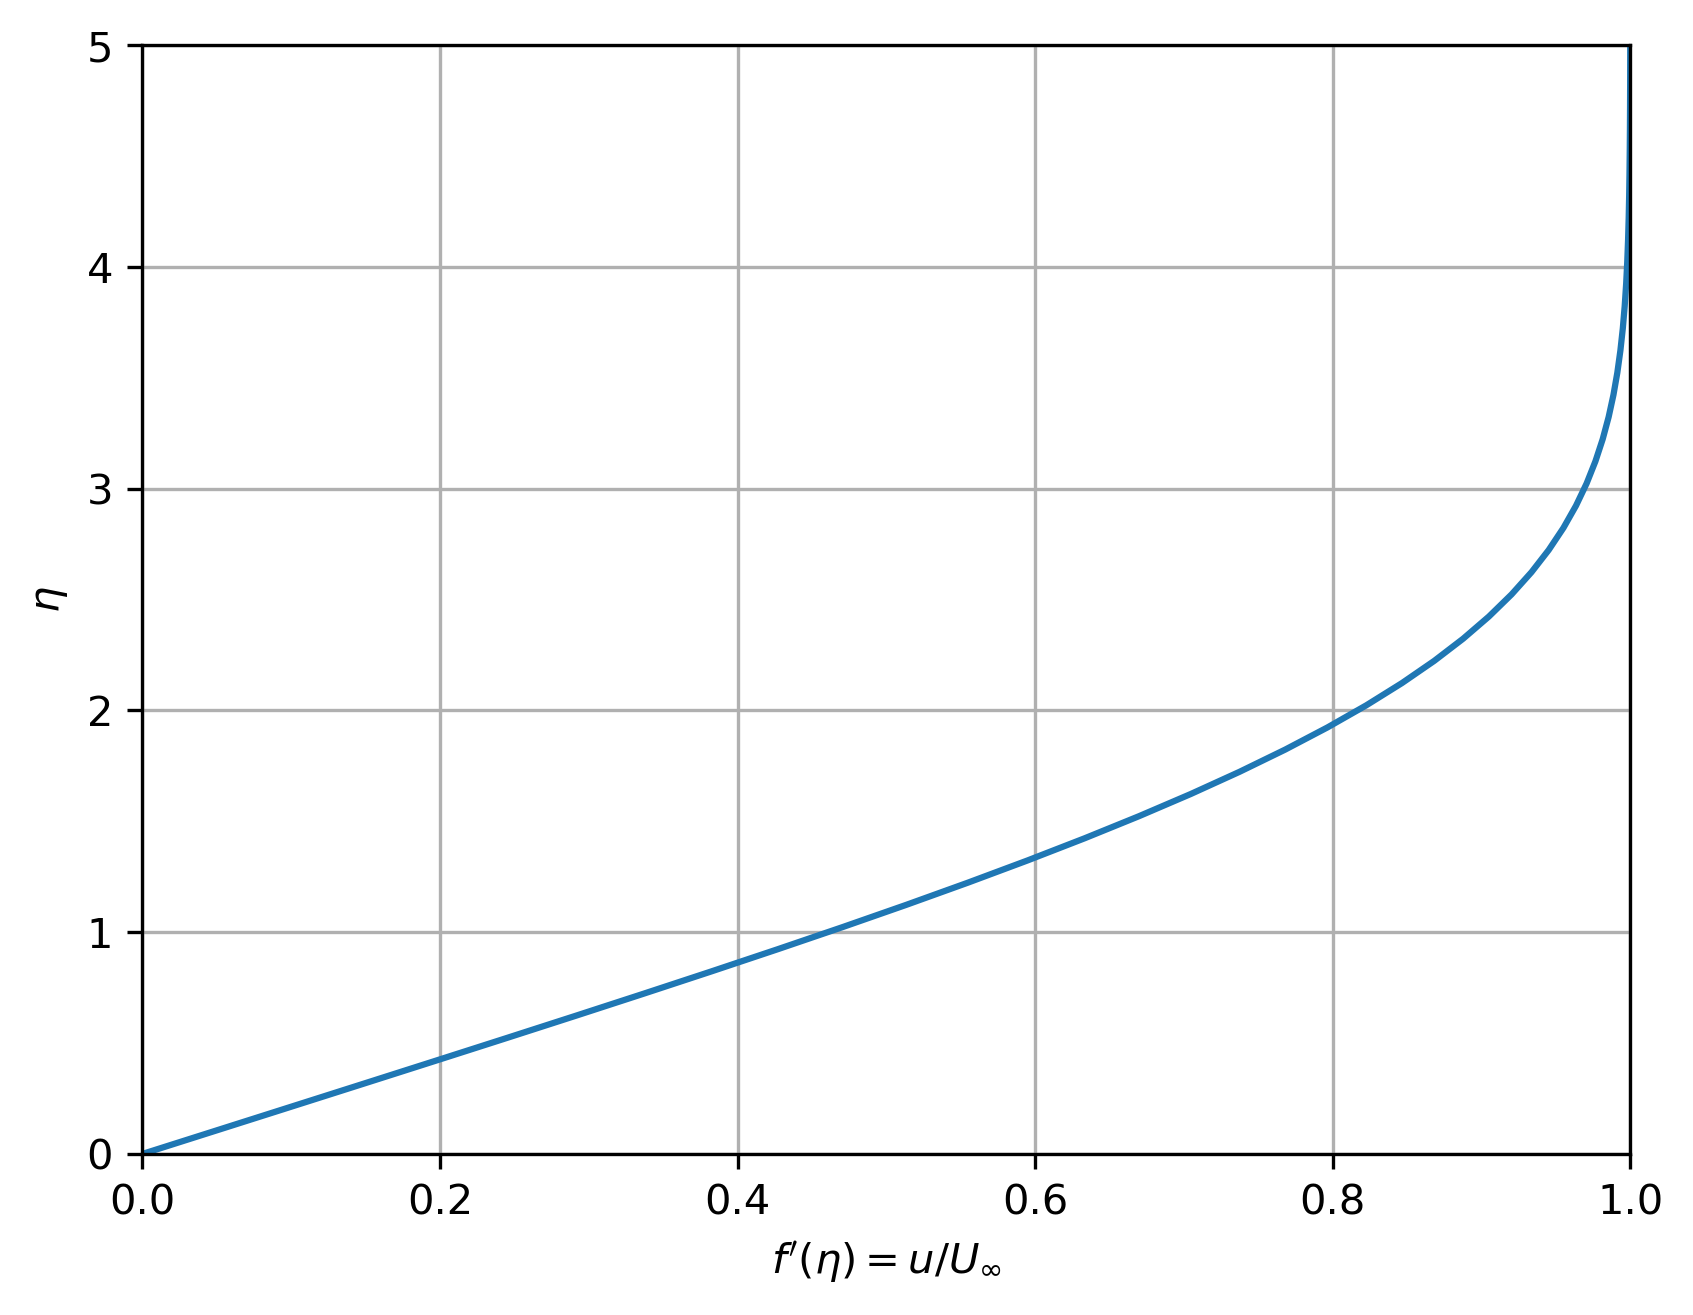

In [30]:
plt.plot(sol.y[1,:], sol.t)
plt.ylabel(r'$\eta$')
plt.xlabel(r'$f^{\prime}(\eta) = u/U_{\infty}$')
plt.ylim([0, 5])
plt.xlim([0, 1])
plt.grid()
plt.show()

We can see that this plot of $\eta$, the $y$ position normalized by the boundary-layer thickness, vs. nondimensional velocity matches the original figure.